In [1]:
import os
os.chdir('/home/golopes/mestrado/projetos/FoodAid/')

import numpy as np
import pandas as pd
import spacy
nlp = spacy.load('en_core_web_sm', disable=['lemmatizer', 'tagger', 'ner'])
from ingredient_parser import ingredient_parser
from keras_preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from pattern.text.en import singularize
import keras

def get_labels(df, tokenized_instructions):
    labels = []
    dic_ing={}
    for ing, ti in zip(df["ingredients"], tokenized_instructions):
        l_i = []
        ci = ingredient_parser(ing)
        for i in ci:
            if i not in dic_ing.keys():
                dic_ing[i] = len(dic_ing)
        for token in ti:
            l_i.append(any((c == token.text or c == singularize(token.text) or singularize(c) == token.text) for c in ci))
        labels.append(l_i)
    return labels,dic_ing
            
def prepare_sequences(texts, max_len, vocab={"<UNK>": 1, "<PAD>": 0}):
    X = [[vocab.get(w.text, vocab["<UNK>"]) for w in s] for s in texts]
    return pad_sequences(maxlen=max_len, sequences=X, padding="post", value=vocab["<PAD>"])

/home/golopes/anaconda3/envs/work/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-15 18:20:36.561461: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
eval_size =10

df = pd.read_csv("csv_file/recipes.csv")
df=df.sample(frac=1).reset_index(drop=True)

df = df[eval_size:].reset_index(drop=True)
eval_df = df[:eval_size]

tokenized = [nlp(t) for t in df.recipe.values]

vocab = {"<UNK>": 1, "<PAD>": 0}
for txt in tokenized:
    for token in txt:
        if singularize(token.text) not in vocab.keys():
            vocab[singularize(token.text)] = len(vocab)
print("Number of unique tokens: {}".format(len(vocab)))

labels,dic_ing = get_labels(df, tokenized)


Number of unique tokens: 534


In [3]:
i=30
print(tokenized[i])
print(df.ingredients[i])
set([t.text for t, l in zip(tokenized[i], labels[i]) if l])

Peel and chop the vegetables. In a pot, sauté the onion and garlic in olive oil until translucent. Add the vegetables and bay leaf, and cook for a few minutes. Add the vegetable broth, season with salt and black pepper, and simmer for about 30 minutes, until the vegetables are tender.
potatoes, carrots, turnip, onion, garlic, olive oil, bay leaf, vegetable broth, salt, black pepper


{'bay',
 'broth',
 'garlic',
 'oil',
 'olive',
 'onion',
 'pepper',
 'salt',
 'vegetable',
 'vegetables'}

In [4]:
MAX_LEN = 400
epoch_nr=10
X_seq = prepare_sequences(tokenized, max_len=MAX_LEN, vocab=vocab)

y_seq = []
for l in labels:
    y_i = []
    for i in range(MAX_LEN):
        try:
            y_i.append(float(l[i]))
        except:
            y_i.append(0.0)
    y_seq.append(np.array(y_i))
y_seq = np.array(y_seq)
y_seq = y_seq.reshape(y_seq.shape[0], y_seq.shape[1], 1)

class NLModel(keras.Model):
    def __init__(self, vocab_len, output_dim,name=None):
        super().__init__(name=name)
        self.vocab_len = vocab_len
        self.output_dim=output_dim
        
        self.model = tf.keras.Sequential([
            layers.Embedding(input_dim=vocab_len, mask_zero=True, output_dim=output_dim),
            layers.SpatialDropout1D(0.2),
            layers.Bidirectional(layers.LSTM(units=64, return_sequences=True)),
            layers.SpatialDropout1D(0.2),
            layers.Bidirectional(layers.LSTM(units=64, return_sequences=True)),
            layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))
        ])

    def call(self, inputs):
        x = self.model(inputs)
        return x

    # def get_config(self):
    #     return {"output_dim": self.output_dim, "vocab_len": self.vocab_len}

model=NLModel(len(vocab),50)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_seq, y_seq, epochs=epoch_nr, batch_size=256, validation_split=0.1)

2023-04-15 18:20:51.972710: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 18:20:51.974251: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/10
1/1 [==============================] - 22s 22s/step - loss: 0.6946 - accuracy: 0.3395 - val_loss: 0.6827 - val_accuracy: 0.8567
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.6822 - accuracy: 0.8694 - val_loss: 0.6709 - val_accuracy: 0.8567
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.6697 - accuracy: 0.8694 - val_loss: 0.6567 - val_accuracy: 0.8567
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.6547 - accuracy: 0.8694 - val_loss: 0.6387 - val_accuracy: 0.8567
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.6361 - accuracy: 0.8694 - val_loss: 0.6158 - val_accuracy: 0.8567
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.6129 - accuracy: 0.8694 - val_loss: 0.5864 - val_accuracy: 0.8567
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.5811 - accuracy: 0.8694 - val_loss: 0.5495 - val_accuracy: 0.8567
Epoch 8/10
1/1 [=======================

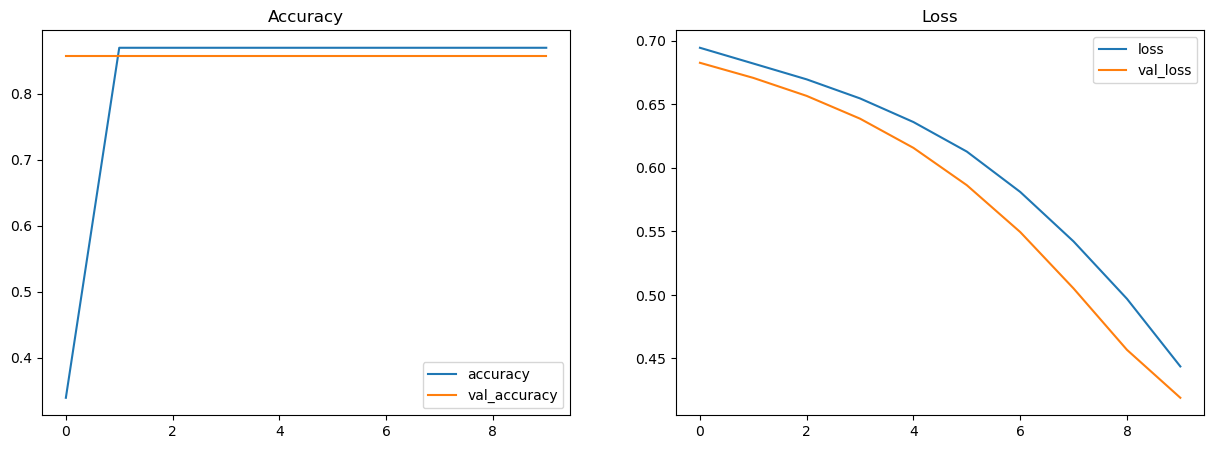

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(history.history["accuracy"])
ax2.plot(history.history["loss"])
ax1.plot(history.history['val_'+"accuracy"])
ax2.plot(history.history['val_'+"loss"])
ax1.set_title("Accuracy")
ax2.set_title("Loss")
ax1.legend(["accuracy", 'val_'+"accuracy"])
ax2.legend(["loss", 'val_'+"loss"])

In [6]:
eval_ingredients = eval_df.ingredients.values
recipe=eval_df.recipe.values.tolist()
eval_tokenized = []
for t in recipe:
    try:
        eval_tokenized.append(nlp(t.replace("\n"," ")))
    except:
        print(t)

X_seq_test = prepare_sequences(eval_tokenized, max_len=MAX_LEN, vocab=vocab)

y_pred_test = model.predict(X_seq_test, verbose=1, batch_size=5)


2/2 [==============================] - 4s 166ms/step


In [7]:

i = 9
pred_i = y_pred_test[i] > 0.01
ingreds = [t.text for t, p in zip(eval_tokenized[i], pred_i) if p]
set(ingreds)
ing_ver=[]
for j in ingreds:
    if singularize(j) in dic_ing.keys() and j not in ing_ver:
        ing_ver.append(j)
        
print('Recipe: ' + str(eval_tokenized[i]))  
print('Csv Ingredients: ' + eval_ingredients[i])     
print()
print('Predicted Ingredients: ',end="")
[print(i,end=", ") for i in set(ingreds)]
print()
print('Predicted Ingredients after Clean: ',end="")
[print(i,end=", ") for i in ing_ver]
print()

Recipe: Heat a large pot over medium-high heat. Add the chicken and cook until browned on all sides. Add the onion and garlic to the pot and sauté until softened. Add the carrots, potatoes, green beans, chickpeas, chicken broth, bay leaf, and paprika to the pot. Bring to a boil, then reduce the heat and let simmer for 45 minutes to 1 hour, or until the vegetables are tender and the chicken is cooked through. Season with salt and pepper to taste before serving.
Csv Ingredients: chicken,onion,garlic ,carrots,potatoes,green beans,chickpeas,chicken broth,bay leaf,paprika,Salt , pepper

Predicted Ingredients: are, vegetables, large, ,, through, Add, leaf, pot, before, until, over, bay, chickpeas, taste, the, onion, pepper, for, Bring, Season, sauté, hour, broth, serving, beans, 45, is, garlic, salt, minutes, chicken, simmer, potatoes, browned, or, softened, tender, carrots, paprika, cook, medium, -, let, all, Heat, to, reduce, with, heat, 1, on, then, a, ., cooked, sides, and, boil, green, 

In [8]:
input_txt = open("test.txt", "r")

input_tokenized=[]
input_tokenized.append(nlp(input_txt.read()))
inp_seq = prepare_sequences(input_tokenized, max_len=MAX_LEN, vocab=vocab)
out_seq = model.predict(inp_seq, verbose=1, batch_size=1)

predict = out_seq > 0.05
        
print('Recipe: ' + str(input_tokenized[0]))
print()
ingreds_test = [t.text for t, p in zip(input_tokenized[0], predict[0]) if p]
set(ingreds_test)
ing=[]
for i in ingreds_test:
    if i in dic_ing.keys() and i not in ing:
        ing.append(i)
print('Ingredients: ',end="")
[print(i,end=", ") for i in ing]
print()


1/1 [==============================] - 5s 5s/step
Recipe: 2 beef beer ingredients 500g cheap beef pieces stewing steak usually cheap 500 mls real ale 4 large onions 2 fat cloves garlic tbsp plain flour method raw beef roll flour fry 4 5 pieces time hot saucepan seal put one side done cut onions quarters fry frying pan beef soak juices towards end frying onion nicely brown round edges throw smashed cloves garlic transfer beef onions garlic deep casserole dish stir remaining flour pour bottle beer really going wasted cover cook 150 2 half hours gorgeous comes trust serve mash "" 3 pad thai chicken 4 servings ingredients essential items rice noodles use another type noodle read packet instructions cook 2 chicken breasts salt pepper 3 medium red chillis chopped 3 spring onions chopped 2 eggs corriander corriander substitute dried mint 1 tbsp lemon juice 1 tbsp brown sugar 2 cloves garlic minced 3 tbsp fish sauce following ingredients essential afford taste fantastic dish 60g cooked shrimp 

In [9]:
import pickle

tf.saved_model.save(model, 'NL/model/recipe_ing_model.h5')

with open('NL/save/vocab.pkl', 'wb') as fp:
    pickle.dump(vocab, fp)
    
with open('NL/save/ingred_vocab.pkl', 'wb') as fp:
    pickle.dump(dic_ing, fp)

INFO:tensorflow:Assets written to: NL/recipe_ing_model.h5/assets


INFO:tensorflow:Assets written to: NL/recipe_ing_model.h5/assets


In [10]:
with open('NL/save/vocab.pkl', 'rb') as fp:
        vocab = pickle.load(fp)
        
with open('NL/save/ingred_vocab.pkl', 'rb') as fp:
    dic_ing = pickle.load(fp)

model = tf.saved_model.load('NL/model/recipe_ing_model.h5')

input = open("test.txt", "r")

input_tokenized=[]
input_tokenized.append(nlp(input.read()))
inp_seq = prepare_sequences(input_tokenized, max_len=MAX_LEN, vocab=vocab)
out_seq = model(inp_seq)

predict = out_seq > 0.05
ingreds_test = [t.text for t, p in zip(input_tokenized[0], predict[0]) if p]
set(ingreds_test)
ing=[]
for i in ingreds_test:
    if i in dic_ing.keys() and i not in ing:
        ing.append(i)

print('Ingredients: ',end="")
[print(i,end=", ") for i in ing]
print()

2023-04-15 18:23:20.049774: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2023-04-15 18:23:20.065248: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2023-04-15 18:23:20.280271: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2023-04-15 18:23:21.083148: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2023-04-15 18:23:21.113377: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _ou

Ingredients: beef, beer, steak, garlic, flour, roll, onion, chicken, rice, salt, pepper, lemon, sugar, fish, sauce, shrimp, water, oil, bean, 


: 